A demonstration of the MaskMaker class to build and use regional masking

MaskMasker is a class of methods to assist with making regional masks within COAsT.
Presently the mask generated are external to MaskMaker.
Masks are constructed as gridded boolean numpy array for each region, which are stacked over a dim_mask dimension. 
The mask arrays are generated on a supplied horizontal grid. The masks are then stored in xarray objects along with regions names.

Examples are given working with Gridded and Profile data.

### Relevant imports and filepath configuration

In [1]:
import warnings
warnings.filterwarnings('ignore')

import coast
import numpy as np
from os import path
import matplotlib.pyplot as plt
import matplotlib.colors as colors  # colormap fiddling
import xarray as xr

/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/users/train006/.conda/envs/coast_wrk_shp/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#ke

In [2]:
# user directory
uid = "train006"
# analysis year and month
year = 2007
month = 1
# yyyymm format
yyyymm = str(year) + str(month).zfill(2)

In [3]:
# set some paths
path = "/gws/pw/j07/workshop/users/AMM/AMM7_SSB_sample/"
model_path = path +  "amm7_1d_{0}01_{0}31_grid_T.nc".format(yyyymm)
jmmp_path = "/gws/nopw/j04/jmmp/"
domcfg_path = path + "amm7_SSB_mesh_mask.nc"

Set coast config paths. COAST uses configuration files to map model variables to common variable names.

In [4]:
cfg_path = "/home/users/{}/CLASS_workshop/Analysis/AMM/COAST_CFG/".format(uid)
en4_json = cfg_path + "example_en4_profiles.json"
nemo_json = cfg_path + "example_nemo_grid_t.json"

### Loading data

In [5]:
# Create a Gridded object and load in the data:
nemo = coast.Gridded(model_path, domcfg_path, config=nemo_json)

# Initialise MaskMaker and define target grid


In [6]:
mm = coast.MaskMaker()

# Define Regional Masks
regional_masks = []

# Define convenient aliases based on nemo data
lon = nemo.dataset.longitude.values
lat = nemo.dataset.latitude.values
bathy = nemo.dataset.bathymetry.values


# Use MaskMaker to define new regions

MaskMaker can build a stack of boolean masks in an xarray dataset for regional analysis. Regions can be supplied by providing vertices coordiates to the `make_region_from_vertices` method. (Vertices coordinates can be passed as xarray objects or as numpy arrays).
The method returns a numpy array of booleans.

In [7]:
# Draw and fill a square
vertices_lon = [-5, -5, 5, 5]
vertices_lat = [40, 60, 60, 40]

# input lat/lon as xr.DataArray
filled1 = mm.make_region_from_vertices(nemo.dataset.longitude, nemo.dataset.latitude, vertices_lon, vertices_lat)

The boolean numpy array can be converted to an xarray object using `make_mask_dataset()` for improved interactions with other xarray objects. 

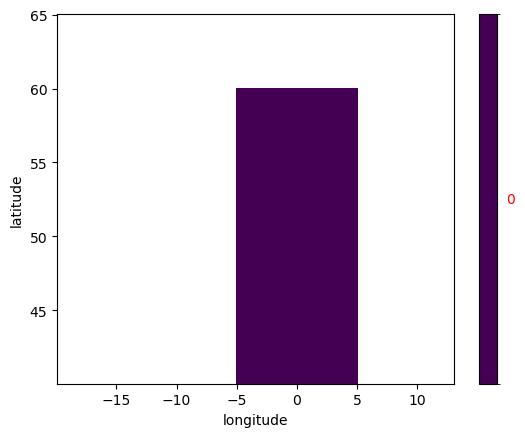

In [8]:
mask_xr = mm.make_mask_dataset(nemo.dataset.longitude.values, nemo.dataset.latitude.values, filled1)

mm.quick_plot(mask_xr)

# Use MaskMaker for predefined regions

The NWS has a number of predefined regions. These are numpy boolean arrays as functions of the specified latitude, longitude and bathymetry. They can be appended into a list of arrays, which can be similarly converted into an xarray object.

In [9]:
masks_list = []

# Add regional mask for whole domain
masks_list.append(np.ones(lon.shape))

# Add regional mask for English Channel
masks_list.append(mm.region_def_nws_north_north_sea(lon, lat, bathy))
masks_list.append(mm.region_def_nws_south_north_sea(lon, lat, bathy))
masks_list.append(mm.region_def_nws_outer_shelf(lon, lat, bathy))
masks_list.append(mm.region_def_nws_norwegian_trench(lon, lat, bathy))
masks_list.append(mm.region_def_nws_english_channel(lon, lat, bathy))
masks_list.append(mm.region_def_nws_off_shelf(lon, lat, bathy))
masks_list.append(mm.region_def_nws_irish_sea(lon, lat, bathy))
masks_list.append(mm.region_def_nws_kattegat(lon, lat, bathy))
masks_list.append(mm.region_def_nws_fsc(lon, lat, bathy))

masks_names = ["whole domain", "northern north sea", "southern north sea", "outer shelf",
               "norwegian trench", "english_channel",  "off shelf",
                "irish sea", "kattegat", "fsc"]

As before the numpy arrays (here as a list) can be converted into an xarray dataset where each mask is separated along the `dim_mask` dimension

In [10]:
mask_xr = mm.make_mask_dataset(lon, lat, masks_list, masks_names)

In [11]:
# Inspect mask xarray object structure

mask_xr

<xarray.Dataset>
Dimensions:       (y_dim: 375, x_dim: 297, dim_mask: 10)
Coordinates:
    longitude     (y_dim, x_dim) float32 -19.89 -19.78 -19.67 ... 12.89 13.0
    latitude      (y_dim, x_dim) float32 40.07 40.07 40.07 ... 65.0 65.0 65.0
    region_names  (dim_mask) <U18 'whole domain' 'northern north sea' ... 'fsc'
Dimensions without coordinates: y_dim, x_dim, dim_mask
Data variables:
    mask          (dim_mask, y_dim, x_dim) float64 1.0 1.0 1.0 ... 0.0 0.0 0.0

## Plot masks

Inspect the mask with a `quick_plot()` method.

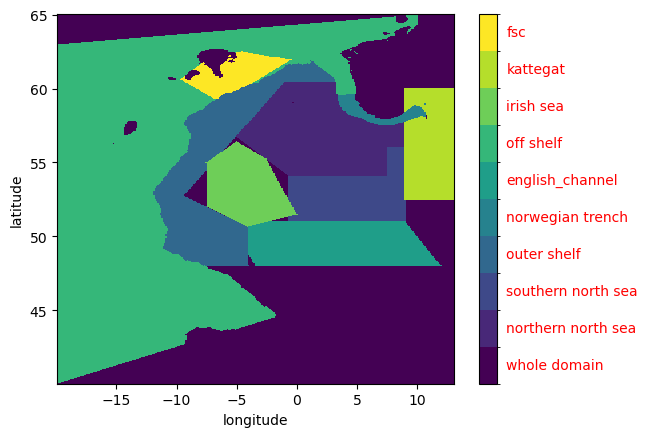

In [12]:
mm.quick_plot(mask_xr)

NB overlapping regions are not given special treatment, the layers are blindly superimposed on each other. E.g. as demonstrated with "Norwegian Trench" and "off shelf", "FSC" and "off shelf", or "whole domain" and any other region.

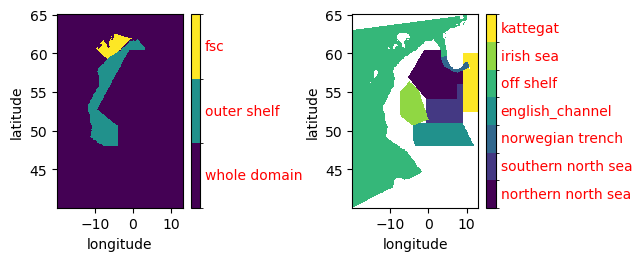

In [13]:
plt.subplot(2,2,1)
mm.quick_plot(mask_xr.sel(dim_mask=[0,3,9]))

plt.subplot(2,2,2)
mm.quick_plot(mask_xr.sel(dim_mask=[1,2,4,5,6,7,8]))

plt.tight_layout()

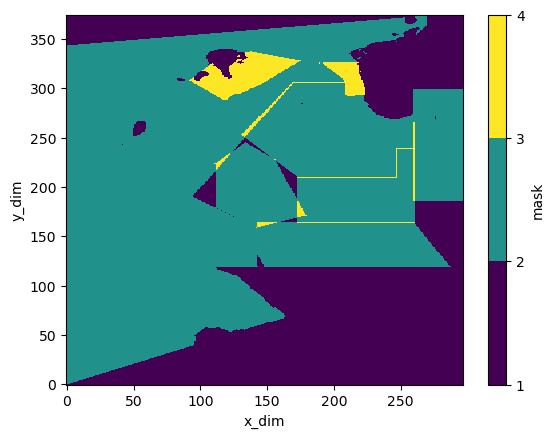

In [14]:
# Show overlap
mask_xr.mask.sum(dim='dim_mask').plot(levels=(1,2,3,4))

# Regional analysis with Profile data

Apply the regional masks to average SST

In [15]:
# Read EN4 data into profile object
en4_path="/gws/pw/j07/workshop/users/AMM/EN4/"
fn_prof = en4_path + "AMM15_processed_{}.nc".format(yyyymm)
en4_profiles = coast.Profile(config=en4_json)
#profile.read_en4( fn_prof )
en4_profiles.dataset = xr.open_dataset(fn_prof, chunks={'id_dim':10000})

/home/users/train006/CLASS_workshop/Analysis/AMM/COAST_CFG/example_en4_profiles.json


Then we use `ProfileAnalysis.determine_mask_indices()` to figure out which profiles in a Profile object lie within each regional mask:

In [16]:
analysis = coast.ProfileAnalysis()
mask_indices = analysis.determine_mask_indices(en4_profiles, mask_xr)

This returns an object called `mask_indices`, which is required to pass to `ProfileAnalysis.mask_means()`. This routine will return a new xarray dataset containing averaged data for each region:

In [17]:
profile_mask_means = analysis.mask_means(en4_profiles, mask_indices)

This routine operates over all variables in the `profile` object. It calculates means by region preserving depth information (`profile_mean_*`) and also averaging over depth information (`all_mean_*`). The variables are returned with these prefixes accordingly. 

In [18]:
profile_mask_means

<xarray.Dataset>
Dimensions:                             (dim_mask: 9, z_dim: 400)
Coordinates:
    region_names                        (dim_mask) <U18 'whole domain' ... 'k...
Dimensions without coordinates: dim_mask, z_dim
Data variables: (12/20)
    profile_mean_depth                  (dim_mask, z_dim) float32 6.381 ... nan
    profile_mean_potential_temperature  (dim_mask, z_dim) float32 8.948 ... nan
    profile_mean_temperature            (dim_mask, z_dim) float32 8.949 ... nan
    profile_mean_practical_salinity     (dim_mask, z_dim) float32 33.6 ... nan
    profile_mean_qc_flags_profiles      (dim_mask) float64 1.608e+05 ... 3.39...
    profile_mean_qc_flags_levels        (dim_mask, z_dim) float64 8.141e+06 ....
    ...                                  ...
    all_mean_qc_flags_profiles          (dim_mask) float64 1.608e+05 ... 3.39...
    all_mean_qc_flags_levels            (dim_mask) float64 2.588e+07 ... 3.35...
    all_mean_reject_tem_prof            (dim_mask) float64 0.0 0.0 ... 0.0 0.0
    all_mean_reject_sal_prof            (dim_mask) float64 0.04297 ... 0.1621
    all_mean_reject_tem_datapoint       (dim_mask) float64 0.7722 ... 0.9866
    all_mean_reject_sal_datapoint       (dim_mask) float64 0.7727 ... 0.9904

Notice that the number of mask dimensions is not necessarily preserved between the mask and the mask averaged variables. This happens if, for example, there are no profiles in one of the mask regions

In [19]:
check1 = mask_indices.dims["dim_mask"] == profile_mask_means.dims["dim_mask"]
print(check1)

False


The mean profiles can be visualised or further processed (notice the Irish Sea region and FSC are missing because there were no profiles in the example dataset)

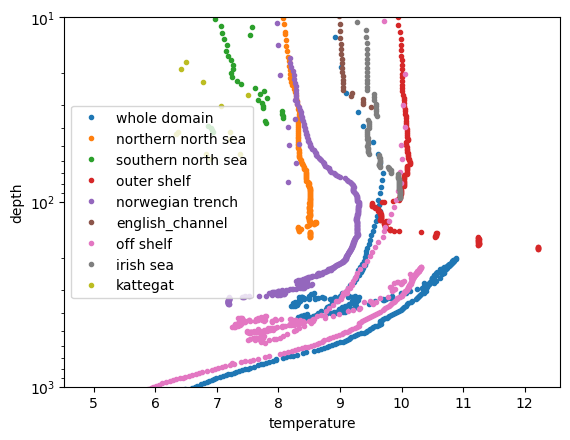

In [20]:
for count_region in range(profile_mask_means.sizes['dim_mask']):    
    plt.plot( 
            profile_mask_means.profile_mean_temperature.isel(dim_mask=count_region),
            profile_mask_means.profile_mean_depth.isel(dim_mask=count_region),
            label=profile_mask_means.region_names[count_region].values,
            marker=".", linestyle='none')

plt.ylim([10,1000])
plt.yscale("log")
plt.gca().invert_yaxis()
plt.xlabel('temperature'); plt.ylabel('depth')
plt.legend()


# Regional analysis with Gridded data

Apply the regional masks to average SST. This is done manually as there are not yet COAsT methods to broadcast the operations across all variables.

In [21]:
# Syntax: xr.where(if <first>, then <2nd>, else <3rd>) 
mask_SST = xr.where( mask_xr.mask, nemo.dataset.temperature.isel(z_dim=0), np.NaN)

# Take the mean over space for each region
mask_mean_SST = mask_SST.mean(dim="x_dim").mean(dim="y_dim")

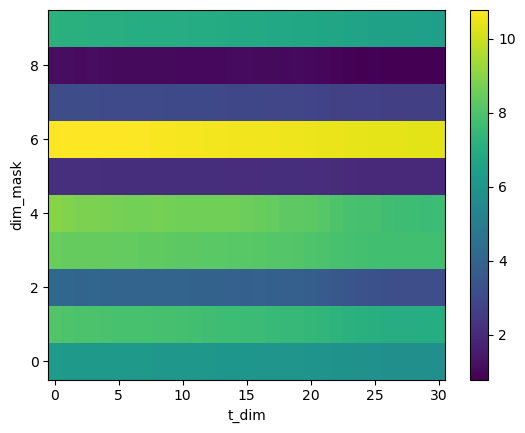

In [22]:
# Inspect the processed data
mask_mean_SST.plot()

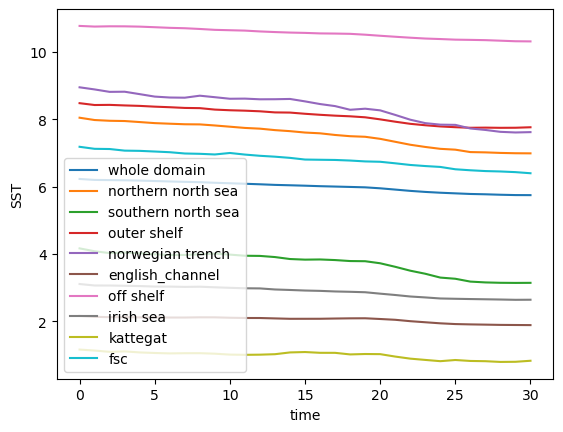

In [23]:
# Plot timeseries per region

for count_region in range(mask_mean_SST.sizes['dim_mask']):
    
    plt.plot( 
        mask_mean_SST.isel(dim_mask=count_region),
        label=mask_mean_SST.region_names[count_region].values,
        )

plt.xlabel('time'); plt.ylabel('SST')
plt.legend()